### Import model from models/

In [47]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, BatchSampler
import random

class RandomBatchSampler(BatchSampler):
    def __init__(self, sampler, batch_size, drop_last):
        super().__init__(sampler, batch_size, drop_last)
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        # Each time __iter__ is called, randomize the batch indices
        batch_indices = list(self.sampler)
        random.shuffle(batch_indices)
        
        # Return batches of size batch_size
        for i in range(0, len(batch_indices), self.batch_size):
            yield batch_indices[i:i + self.batch_size]

# Create a random sampler for the dataset
sampler = SubsetRandomSampler(range(len(dataset)))

# Create a batch sampler that returns random batches every time
batch_sampler = RandomBatchSampler(sampler, batch_size=16, drop_last=False)

# Create the DataLoader using the batch sampler
dataloader = DataLoader(dataset, batch_sampler=batch_sampler)

# Now every time you call the dataloader, it will give a random batch
for random_batch in dataloader:
    # Do something with random_batch
    print(random_batch)


['f', 'e', 'd', 'u', 't', 'a', 'l', 's', 'a', '_', 'l', 't']


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from decifer import (
    HDF5Dataset,
)
from tqdm.auto import tqdm
from time import time
import torch.nn.functional as F

import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser

# Function to extract spacegroup from CIF metadata
def extract_spacegroup_from_metadata(cif_string):
    try:
        parser = CifParser.from_string(cif_string)
    except:
        parser = CifParser.from_str(cif_string)
    # Get CIF data (metadata) from the first parsed structure
    cif_data = parser.as_dict()
    
    # Extract the spacegroup directly from metadata
    for key in cif_data:
        spacegroup = cif_data[key].get('_symmetry_Int_Tables_number')
        if spacegroup:
            return int(spacegroup) / 230
    return None  # Return None if no spacegroup is found

class SimpleModel(nn.Module):
    def __init__(self, vocab_size, token_input_size, numeric_input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        
        # Tokenized data goes through embedding and a simple feedforward layer
        self.embedding = nn.Embedding(vocab_size, token_input_size)  # Adjust vocabulary size
        self.fc_token = nn.Linear(token_input_size, hidden_size)
        self.fc_token_2 = nn.Linear(hidden_size, hidden_size)
        self.fc_token_3 = nn.Linear(hidden_size, hidden_size)

        # Final layer to produce the output
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, token_data):
        # Tokenized data
        embedded = self.embedding(token_data)
        token_output = F.elu(self.fc_token(embedded.mean(dim=1)))  # Take mean across tokens
        token_output = F.elu(self.fc_token_2(token_output))
        token_output = F.elu(self.fc_token_3(token_output))

        # Final output
        return F.softmax(self.fc_out(token_output), dim=-1)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, debug_max=None):
    model.train()
    running_loss = 0.0
    cifparser = CifParser
    total_batches = min(len(train_loader), debug_max)
    #print("Total number of batches", total_batches)
    inner_pbar = tqdm(total=total_batches, desc="Training", leave=False)
    for i, batch in enumerate(train_loader):
        # Send data to device (GPU or CPU)
        token_data, numeric_data, cif_batch = batch[0].to(device), batch[1].to(device), batch[2]
        
        #print(cif_batch[0])

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Extract spacegroup
        #print([extract_spacegroup_from_metadata(s) for s in cif_batch])
        spgs = torch.tensor([
            extract_spacegroup_from_metadata(s) for s in cif_batch
        ]).unsqueeze(-1).to(dtype=torch.float32, device=device)

        outputs = model(token_data)
        #loss = criterion(outputs, numeric_data)  # Using numeric data as the target for simplicity
        loss = criterion(outputs, spgs)  # Using numeric data as the target for simplicity
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
         # Update tqdm progress bar
        inner_pbar.set_postfix({'Loss': loss.item()})
        inner_pbar.update(1)

        # Optional debug break to limit iterations
        if debug_max is not None and i > debug_max:
            break
            
    # Close tqdm progress bar
    inner_pbar.close()

    return running_loss / len(train_loader)


# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device, debug_max=None):
    model.eval()
    running_loss = 0.0
    cifparser = CifParser
    with torch.no_grad():
        total_batches = min(len(val_loader),debug_max)
        #print("Total number of batches", total_batches)
        inner_pbar = tqdm(total=total_batches, desc="Validating", leave=False)
        for i, batch in enumerate(val_loader):
            token_data, numeric_data, cif_batch = batch[0].to(device), batch[1].to(device), batch[2]
            
            # Extract spacegroup
            spgs = torch.tensor([
                extract_spacegroup_from_metadata(s) for s in cif_batch
            ]).unsqueeze(-1).to(dtype=torch.float32, device=device)

            outputs = model(token_data)
            #loss = criterion(outputs, numeric_data)  # Using numeric data as the target for simplicity
            loss = criterion(outputs, spgs)  # Using numeric data as the target for simplicity

            running_loss += loss.item()
            
             # Update tqdm progress bar
            inner_pbar.set_postfix({'Loss': loss.item()})
            inner_pbar.update(1)
            
            # Optional debug break to limit iterations
            if debug_max is not None and i > debug_max:
                break
                
        inner_pbar.close()

    return running_loss / len(val_loader)


def sample(model, val_loader, device, debug_max=None):
    model.eval()
    with torch.no_grad():
       
        for i, batch in enumerate(val_loader):
            token_data, numeric_data = batch[0].to(device), batch[1].to(device)
            outputs = model(token_data)
            
            plt.figure()
            plt.plot(numeric_data[0].cpu().numpy(), label='Label')
            plt.plot(outputs[0].cpu().numpy(), label='gen')
            plt.legend()
            plt.show()
        
            # Optional debug break to limit iterations
            if debug_max is not None and i > debug_max:
                break
                
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Simple training loop
def run_training(train_loader, val_loader, vocab_size, token_input_size, numeric_input_size, hidden_size, output_size, epochs=5, debug_max=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, loss function, and optimizer
    model = SimpleModel(vocab_size, token_input_size, numeric_input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Print the number of parameters in the model
    total_params = count_model_parameters(model)
    print(f"Total number of parameters: {total_params}")
    
    # Lists to track losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device, debug_max)
        val_loss = evaluate_model(model, val_loader, criterion, device, debug_max)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses


In [21]:
dataset = "full_dataset"

# Example dataset loading (adjust paths as necessary)
block_size = 1000
train_dataset = HDF5Dataset(f'../data/chili100k/{dataset}/hdf5_data/train_dataset.h5', 
                            ['xrd_tokenized', 'xrd_cont_y', 'cif_content'], block_size)

val_dataset = HDF5Dataset(f'../data/chili100k/{dataset}/hdf5_data/val_dataset.h5', 
                          ['xrd_tokenized', 'xrd_cont_y', 'cif_content'], block_size)

test_dataset = HDF5Dataset(f'../data/chili100k/{dataset}/hdf5_data/test_dataset.h5', 
                           ['xrd_tokenized', 'xrd_cont_y', 'cif_content'], block_size)

# Load metadata
import json

# Open and read the JSON file
with open(f'../data/chili100k/{dataset}/metadata.json', 'r') as file:
    data = json.load(file)

# Print the data
# print(data)

vocab_size = data['vocab_size']
numeric_input_size = data['xrd_parameters']['qgrid_len']  # Size of numeric input
#output_size = data['xrd_parameters']['qgrid_len']  # Output size (same as input size for simplicity)
output_size = 1

token_input_size = 32  # Embedding size for tokenized input
hidden_size = 32  # Size of hidden layers

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
debug_max = 1000
trained_model, train_losses, val_losses = run_training(train_loader, val_loader, vocab_size, token_input_size, 
                             numeric_input_size, hidden_size, output_size, epochs=50, debug_max=debug_max)

Total number of parameters: 15105


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

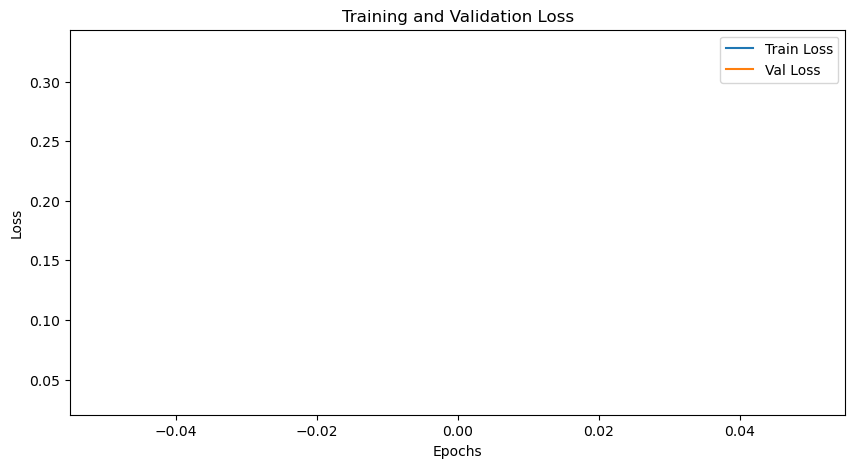

In [14]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# Evaluate on test set (for simplicity)
test_loss = evaluate_model(trained_model, test_loader, nn.MSELoss(), 
                           torch.device('cuda' if torch.cuda.is_available() else 'cpu'), debug_max=debug_max)
print(f"Test Loss: {test_loss:.4f}")

Total number of batches 200


Validating:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_30988/3223846742.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc_out(token_output))


Test Loss: 0.3327


/tmp/ipykernel_30988/3223846742.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc_out(token_output))


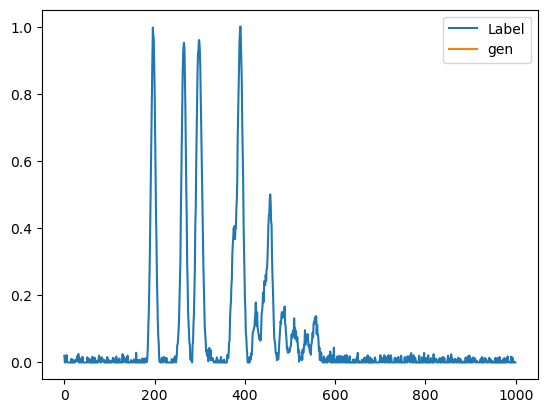

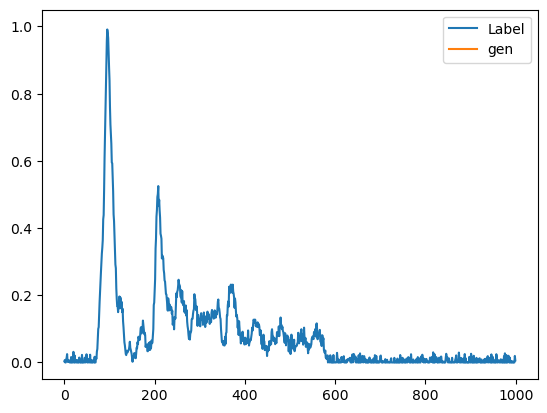

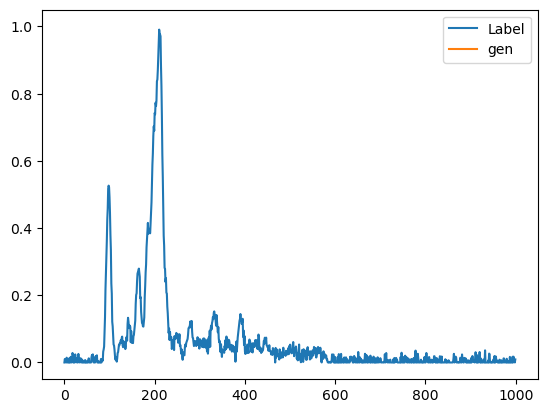

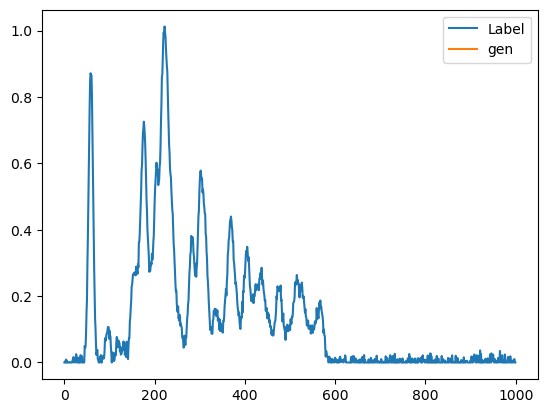

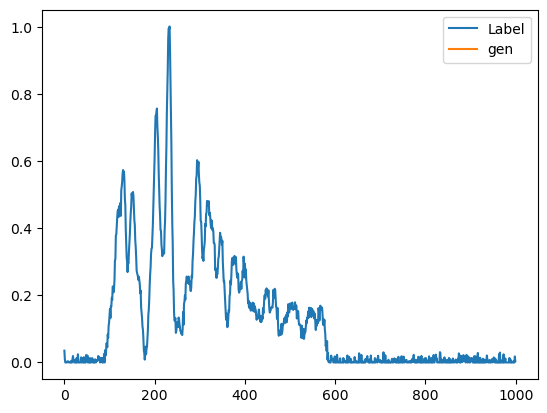

In [10]:
sample(trained_model, val_loader, device='cuda', debug_max=3)